In [1]:
import keras
import os
import typing
import re
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import math
import numpy as np
import cv2
import json
from pathlib import Path

Using TensorFlow backend.


In [2]:
#import all libraries
from PIL import Image, ImageOps,ImageFilter
#import cv2
import time
import argparse
from scipy import ndimage
from scipy import misc
%matplotlib inline
import readline
readline.parse_and_bind("tab: complete")
from scipy import ndimage
from multiprocessing.pool import ThreadPool

from urllib.request import Request, urlopen, HTTPError
import ssl

In [3]:
import os
import numpy as np
import argparse
from keras.models import Model
from PIL import Image, ImageOps,ImageFilter
import matplotlib.image as mpimg
import csv
from numpy import linalg
from pandas import HDFStore

In [18]:


dir_litw_resized=Path("c:/Users/Sanyogita/Documents/Insight/projects/Trademark_RADAR/Git_version/data/resized_images_details_v5")
dir_litw =Path("c:/Users/Sanyogita/Documents/Insight/projects/Trademark_RADAR/Git_version/data/Raw_data_new")
dir_litw_super_cleaned=Path("c:/Users/Sanyogita/Documents/Insight/projects/Trademark_RADAR/Git_version/data/supervised/filtered_supervised_image_v5")


In [82]:
def Get_train_val_test_files(df_image_total_brand_stage,dir_supervised,company_name):
    logo_img_stage_count = len(df_image_total_brand_stage)            
    expected_dimension =120

    logo_imgs_stage = np.ndarray((logo_img_stage_count, 120, 120, 3), dtype=np.uint8)
    logo_img_orig_stage = np.ndarray((logo_img_stage_count, 120, 120, 4), dtype=np.uint8)
    y_stage = np.array(df_image_total_brand_stage['true_logo'])
    index=0
          
    for index_df, record in df_image_total_brand_stage.iterrows():
        
            image_path_info= os.path.join(dir_supervised,company_name,record["logo_file_name"])
          
        # retrieve the image and feed it into mpimg.imread
            img_get = mpimg.imread(image_path_info)
            normalizedImg = cv2.normalize(img_get,None,0,1, cv2.NORM_MINMAX)
            logo_imgs_stage[index] = img_get[:,:,:3]

        
            logo_img_orig_stage[index]=img_get
            index += 1
    
       
    
    return logo_imgs_stage, y_stage, logo_img_orig_stage

In [83]:
def Get_train_val_test_cleaned(company_list,df_filtered):
    X_train_row =[]
    X_orig_train_row =[]
    X_val_row =[]
    X_orig_val_row =[]
    X_test_row=[]
    X_orig_test_row =[]
    y_train_row=[]
    y_val_row=[]
    y_test_row=[]
    
    for index_df, record in company_list.iterrows():
        
        df_image_total_brand = df_filtered[df_filtered["company_brand"] == record["company_brand"]]
        
        df_image_total_brand_train= df_image_total_brand.sample(100, replace=False, random_state=1)
        
        df_image_total_brand_test_validate = df_image_total_brand[~df_image_total_brand.index.isin(df_image_total_brand_train.index)]
        df_image_total_brand_validate = df_image_total_brand_test_validate.sample(12, replace=False, random_state=1)
        df_image_total_brand_test_inter = df_image_total_brand_test_validate[~df_image_total_brand_test_validate.index.isin(df_image_total_brand_validate.index)]
        df_image_total_brand_test = df_image_total_brand_test_inter.sample(12, replace=False, random_state=1)
        company_name=record["company_brand"]
        dir_supervised=dir_litw_super_cleaned
        [X_train_inter,Y_train_inter,X_orig_train_inter]=Get_train_val_test_files(df_image_total_brand_train,dir_supervised,company_name)
        X_train_row.append(X_train_inter)
        y_train_row.append(Y_train_inter)
        X_orig_train_row.append(X_orig_train_inter)
        
        
        [X_val_inter,Y_val_inter,X_orig_val_inter]=Get_train_val_test_files(df_image_total_brand_validate,dir_supervised,company_name)
        X_val_row.append(X_val_inter)
        y_val_row.append(Y_val_inter)
        X_orig_val_row.append(X_orig_val_inter)
        
        [X_test_inter,Y_test_inter,X_orig_test_inter]=Get_train_val_test_files(df_image_total_brand_test,dir_supervised,company_name)
        X_test_row.append(X_test_inter)
        y_test_row.append(Y_test_inter)
        X_orig_test_row.append(X_orig_test_inter)
      
    X_train=np.concatenate(X_train_row)
    X_orig_train=np.concatenate(X_orig_train_row)
    y_train=np.concatenate(y_train_row)
    X_val=np.concatenate(X_val_row)
    X_orig_val=np.concatenate(X_orig_val_row)
    y_val=np.concatenate(y_val_row)
    X_test=np.concatenate(X_test_row)
    y_test=np.concatenate(y_test_row)
    X_orig_test=np.concatenate(X_orig_test_row)

    return X_train,y_train,X_val,y_val,X_test,y_test,X_orig_train,X_orig_val,X_orig_test

In [35]:
def Get_cleaned_supervised_file_info(folder_path_global,folder_brand_name, folder_num):
    df_logos_files_supervised = pd.DataFrame(columns=['true_logo','logo_file_name','company_brand','img_path'])
    
     # in each folder, find image file and resize-scale them without distortion
    index_image= 1
    
    glob_path_complete_path_inter=Path(os.path.join(folder_path_global,folder_brand_name))
    brand_count_row=1
    for filename_logo in glob_path_complete_path_inter.glob('**/*.png'):
         with open(filename_logo) as imagefile:
            image_original = Image.open(filename_logo)
            dir_name,file_orig_name = os.path.split(filename_logo)
           
           
           # mscn_val=calculate_MSCN_values(norm_image)

            row = pd.Series({'true_logo' :folder_num,
                            'logo_file_name' :file_orig_name,
                            'company_brand' :folder_brand_name,
                            'img_path': filename_logo,})
            
            df_logos_files_supervised = df_logos_files_supervised.append(row,ignore_index=True) 
            
            brand_count_row=brand_count_row+1
            index_image =index_image+1


    return df_logos_files_supervised

In [38]:
def Get_cleaned_supervised_folder_info(dir_litw_super):

    
    company_list = pd.DataFrame(columns=['true_logo','company_brand','folder_img_count','folder_path'])
    mn = 120
    folder_logo_num=0 # y_label
    folders = ([name for name in sorted(os.listdir(dir_litw_super), key=str.casefold)]) # get all directories 
    df_list=[]
    for company_name in folders:
        contents = os.listdir(os.path.join(dir_litw_super,company_name)) # get list of contents
        if len(contents) <= mn: # if greater than the limit, print folder and number of contents
            continue
        folder_path_global=dir_litw_super
        #verify_images_df(folder_path_global, company_name,dir_litw, size_threshold,folder_logo_num,expected_dimension)
        df_list.append(Get_cleaned_supervised_file_info(folder_path_global, company_name,folder_logo_num))
        # print(df_list)
        df_image_total_brand = pd.concat(df_list, ignore_index=True) 
        
        folder_path_name=(os.path.join(folder_path_global,company_name))
        row_folder = pd.Series({'true_logo' :folder_logo_num,
                         'company_brand' :company_name,
                        'folder_img_count': len(contents),
                        'folder_path': folder_path_name,})
        
        
        company_list = company_list.append(row_folder,ignore_index=True)   
        #tp_df_stat=pd.concat(df_folder_Stat, ignore_index=True) 
        folder_logo_num=folder_logo_num+1

    return company_list, df_image_total_brand

In [84]:
company_list, df_image_total_brand = Get_cleaned_supervised_folder_info(dir_litw_super_cleaned)


In [81]:
print(company_list)

   true_logo          company_brand folder_img_count  \
0          0               Mod-aldi              142   
1          1        Mod-audi-symbol              125   
2          2            Mod-bionade              166   
3          3  Mod-burgerking-symbol              154   
4          4              Mod-canon              166   
5          5                Mod-cat              145   
6          6          Mod-coca-cola              164   
7          7            Mod-colgate              159   
8          8              Mod-fedex              141   
9          9           Mod-gillette              153   
10        10                Mod-h&m              130   
11        11           Mod-heineken              166   
12        12      Mod-huawei-symbol              131   
13        13              Mod-intel              154   
14        14           Mod-kelloggs              156   
15        15              Mod-kraft              171   
16        16            Mod-nescafe             

In [85]:
[X_train,y_train,X_val,y_val,X_test,y_test,X_orig_train,X_orig_val,X_orig_test]=Get_train_val_test_cleaned(company_list,df_image_total_brand)

In [86]:
print(y_test)

[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 3
 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 6 6
 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 8 8 9 9 9
 9 9 9 9 9 9 9 9 9 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11
 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15
 15 15 15 15 15 15 16 16 16 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17
 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 18 18 19 19 19 19 19 19
 19 19 19 19 19 19 20 20 20 20 20 20 20 20 20 20 20 20 21 21 21 21 21 21
 21 21 21 21 21 21 22 22 22 22 22 22 22 22 22 22 22 22 23 23 23 23 23 23
 23 23 23 23 23 23 24 24 24 24 24 24 24 24 24 24 24 24]


In [87]:
from keras.applications.inception_v3 import InceptionV3
#from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, nadam
from keras import backend as K
from keras.utils import to_categorical
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

In [88]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=2)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
#x = Dropout(0.3)(x)
predictions_layer = Dense(25, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions_layer)
for layer in base_model.layers:
    layer.trainable = True
    


In [89]:
model.summary()
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
y_test_1=np.array(y_test.astype(int64))   

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, None, None, 3 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, None, None, 3 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

NameError: name 'int64' is not defined

In [91]:
y_binary_train = to_categorical(y_train)
y_binary_valid = to_categorical(y_val)
y_binary_test=to_categorical(y_test)
model.fit((X_train), y_binary_train, shuffle=True, validation_data=((X_val), y_binary_valid), 
          batch_size=50, epochs=50, verbose=1, callbacks=[early_stopping])

Train on 2500 samples, validate on 300 samples
Epoch 1/50
2500/2500 [==============================] - 284s 114ms/step - loss: 0.9524 - acc: 0.7384 - val_loss: 1.7167 - val_acc: 0.5167
Epoch 2/50
2500/2500 [==============================] - 278s 111ms/step - loss: 0.6810 - acc: 0.8056 - val_loss: 1.6788 - val_acc: 0.5833
Epoch 3/50
2500/2500 [==============================] - 276s 110ms/step - loss: 0.5404 - acc: 0.8468 - val_loss: 1.7969 - val_acc: 0.5700
Epoch 4/50
2500/2500 [==============================] - 289s 116ms/step - loss: 0.4423 - acc: 0.8796 - val_loss: 1.8218 - val_acc: 0.5533
Epoch 5/50
2500/2500 [==============================] - 288s 115ms/step - loss: 0.3901 - acc: 0.8896 - val_loss: 1.7008 - val_acc: 0.5600
Epoch 00005: early stopping


In [108]:
def print_predict_convert(X_test,y_test):

    predict_test_results = model.predict(X_test)
    
    predict_test_results

    y_test_1=np.array(y_test.astype(np.int64)) 
    # calculate accuracy
    y_predict = np.argmax(predict_test_results, axis=1)

    
    return(predict_test_results,y_test_1,y_test,y_predict)    

In [121]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

def plot_confusion_mat(y_test_1,y_predict):

    cm = confusion_matrix(y_test_1, y_predict)
    

    #plt.rcParams.update({'font.size': 28})
    sns.set(font_scale=1.4)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt='d',cmap="Blues")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

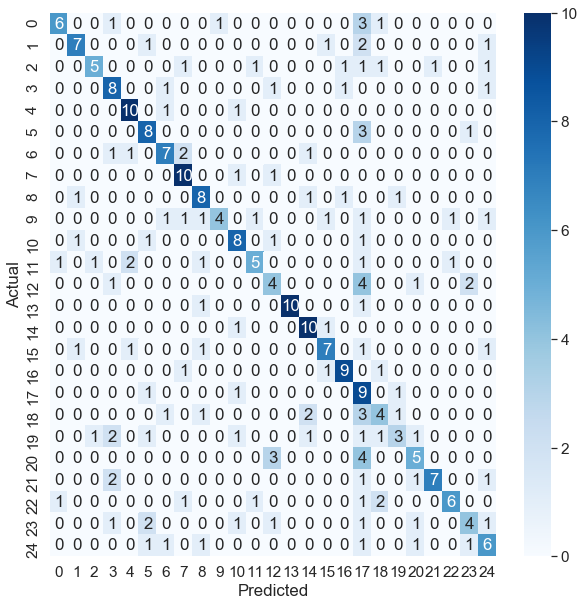

In [122]:
   
[predict_test_results,y_test_1,y_test,y_predict] = print_predict_convert(X_test,y_test)

plot_confusion_mat(y_test_1,y_predict)

In [123]:
import sys
sys.getdefaultencoding()

'utf-8'

In [124]:
from keras.models import load_model
from joblib import dump, load
import pickle
from sklearn.cluster import KMeans

def save_model(model):
    s = pickle.dumps(model)
    dump(model, 'filename_6272019_v1.joblib')
    Inception_feature_list=[]
    #model = load('filename_22.joblib') 
    #model.summary()
    intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer('dense_3').output)
    #predict to get featured data
    feature_engg_data = intermediate_layer_model.predict(X_test)
    feature_engg_data_inter = pd.DataFrame(feature_engg_data)
    print('feauture_engg_data shape:', feature_engg_data_inter.shape)
    return feature_engg_data_inter
    #features_arr = np.char.mod('%f', features)

    #plot_errors(pd_y_test_1,pd_y_predict,X_orig_test)
    #return feauture_engg_data

In [125]:

feature_engg_data_inter = save_model(model)



feauture_engg_data shape: (300, 1024)
